In [45]:
import pandas as pd

# Read the kills data and filter out 2024
kills_df = pd.read_csv('yearly_kills_by_state_modified.csv')
kills_df = kills_df[kills_df['year'] != 2024]

# Read population data and set proper column names for 2013-2019
pop_2013_2019 = pd.read_csv('state_pop_2013_2019.csv', skiprows=4)
years_2013_2019 = ['state', '2010_census', '2010_base', '2010', '2011', '2012', '2013', 
                   '2014', '2015', '2016', '2017', '2018', '2019']
pop_2013_2019.columns = years_2013_2019

# Read population data and set proper column names for 2020-2023
pop_2020_2023 = pd.read_csv('state_pop_2020_2023.csv', skiprows=4)
years_2020_2023 = ['state', '2020_base', '2020', '2021', '2022', '2023']
pop_2020_2023.columns = years_2020_2023

# Filter for state rows and clean state names
pop_2013_2019 = pop_2013_2019[pop_2013_2019['state'].str.startswith('.', na=False)]
pop_2013_2019['state'] = pop_2013_2019['state'].str.replace('.', '')

pop_2020_2023 = pop_2020_2023[pop_2020_2023['state'].str.startswith('.', na=False)]
pop_2020_2023['state'] = pop_2020_2023['state'].str.replace('.', '')

# Melt the dataframes to get year-wise data
pop_2013_2019_melted = pd.melt(pop_2013_2019, 
                              id_vars=['state'],
                              value_vars=['2013', '2014', '2015', '2016', '2017', '2018', '2019'],
                              var_name='year',
                              value_name='population')

pop_2020_2023_melted = pd.melt(pop_2020_2023,
                              id_vars=['state'],
                              value_vars=['2020', '2021', '2022', '2023'],
                              var_name='year',
                              value_name='population')

# Combine population data
pop_df = pd.concat([pop_2013_2019_melted, pop_2020_2023_melted])

# Clean population values and convert to numeric
pop_df['population'] = pop_df['population'].str.replace(',', '')
pop_df['population'] = pd.to_numeric(pop_df['population'], errors='coerce')
pop_df['year'] = pd.to_numeric(pop_df['year'])

# State name mapping dictionary
state_name_mapping = {
    'Alaska': 'AK', 'Alabama': 'AL', 'Arkansas': 'AR', 'Arizona': 'AZ',
    'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE',
    'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Iowa': 'IA',
    'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Massachusetts': 'MA', 'Maryland': 'MD',
    'Maine': 'ME', 'Michigan': 'MI', 'Minnesota': 'MN', 'Missouri': 'MO',
    'Mississippi': 'MS', 'Montana': 'MT', 'North Carolina': 'NC', 'North Dakota': 'ND',
    'Nebraska': 'NE', 'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM',
    'Nevada': 'NV', 'New York': 'NY', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT',
    'Virginia': 'VA', 'Vermont': 'VT', 'Washington': 'WA', 'Wisconsin': 'WI',
    'West Virginia': 'WV', 'Wyoming': 'WY'
}

# Apply state name mapping
pop_df['state'] = pop_df['state'].replace(state_name_mapping)

# Merge with kills data
merged_df = pd.merge(kills_df, pop_df, on=['state', 'year'], how='left')

# Calculate kills per million population
merged_df['kills_per_million'] = (merged_df['total_kills'] / merged_df['population']) * 1000000
merged_df['kills_per_million'] = merged_df['kills_per_million'].round(2)

# Select and arrange final columns
final_df = merged_df[['state', 'year', 'Bodycam_Policy', 'total_kills', 'population', 'kills_per_million']]

# Save to CSV
final_df.to_csv('yearly_kills_by_state_with_per_capita.csv', index=False)

print("First few rows of the result:")
print(final_df.head())
print("\nFile has been saved as 'yearly_kills_by_state_with_per_capita.csv'")

First few rows of the result:
  state  year  Bodycam_Policy  total_kills  population  kills_per_million
0    AK  2013             0.0            4    737068.0               5.43
1    AK  2014             0.0            2    736283.0               2.72
2    AK  2015             0.0            4    737498.0               5.42
3    AK  2016             0.0            7    741456.0               9.44
4    AK  2017             0.0            8    739700.0              10.82

File has been saved as 'yearly_kills_by_state_with_per_capita.csv'


In [46]:
import pandas as pd
import numpy as np

# Read the data
df = pd.read_csv('yearly_kills_by_state_with_per_capita.csv')
# Drop DC
df = df[df['state'] != 'DC']
# dropt unnecessary columns
df = df.drop(columns=['population', 'total_kills'])

# Create state groups
group_1_states = ['CT', 'NJ', 'NM']
group_2_states = ['CO', 'IL', 'MD', 'SC']

# Create the new variable using numpy.select
conditions = [
    df['state'].isin(group_1_states),
    df['state'].isin(group_2_states)
]
choices = [1, 2]
df['treatment'] = np.select(conditions, choices, default=0)

# Save the updated dataframe
df.to_csv('yearly_kills_by_state_with_treatment.csv', index=False)

# Print first few rows and a summary of the groupings
print("First few rows of the result:")
print(df.head())
print("\nNumber of states in each group:")
print(df.groupby('treatment')['state'].nunique())
print("\nStates in each group:")
for group in [0, 1, 2]:
    states = sorted(df[df['treatment'] == group]['state'].unique())
    print(f"\nGroup {group}: {states}")

print("\nFile has been saved as 'yearly_kills_by_state_with_groups.csv'")

First few rows of the result:
  state  year  Bodycam_Policy  kills_per_million  treatment
0    AK  2013             0.0               5.43          0
1    AK  2014             0.0               2.72          0
2    AK  2015             0.0               5.42          0
3    AK  2016             0.0               9.44          0
4    AK  2017             0.0              10.82          0

Number of states in each group:
treatment
0    43
1     3
2     4
Name: state, dtype: int64

States in each group:

Group 0: ['AK', 'AL', 'AR', 'AZ', 'CA', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IN', 'KS', 'KY', 'LA', 'MA', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']

Group 1: ['CT', 'NJ', 'NM']

Group 2: ['CO', 'IL', 'MD', 'SC']

File has been saved as 'yearly_kills_by_state_with_groups.csv'


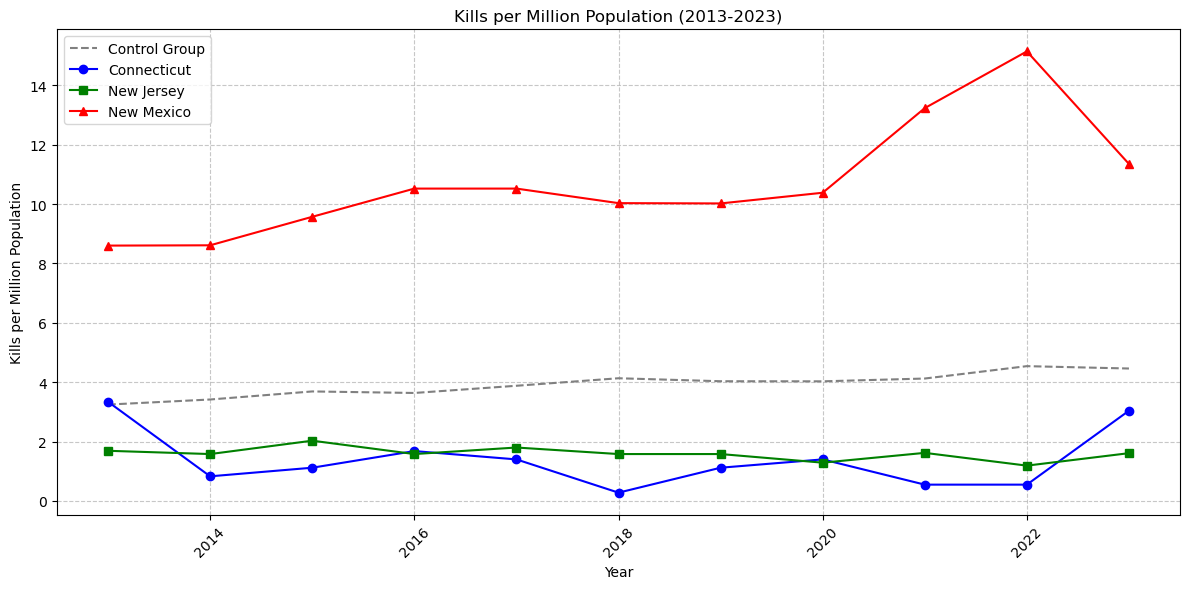


Average kills per million over the entire period:
Control Group: 3.93
Connecticut: 1.39
New Jersey: 1.60
New Mexico: 10.72


In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the data
df = pd.read_csv('yearly_kills_by_state_with_treatment.csv')

# Filter for years 2013-2023
df = df[(df['year'] >= 2013) & (df['year'] <= 2023)]

# Calculate control group average (states with treatment = 0)
control_group = df[df['treatment'] == 0].groupby('year')['kills_per_million'].mean().reset_index()

# Get data for group 1 states (CT, NJ, NM)
ct_data = df[df['state'] == 'CT']
nj_data = df[df['state'] == 'NJ']
nm_data = df[df['state'] == 'NM']

# Create the plot
plt.figure(figsize=(12, 6))

# Plot each line
plt.plot(control_group['year'], control_group['kills_per_million'], '--', label='Control Group', color='gray')
plt.plot(ct_data['year'], ct_data['kills_per_million'], '-o', label='Connecticut', color='blue')
plt.plot(nj_data['year'], nj_data['kills_per_million'], '-s', label='New Jersey', color='green')
plt.plot(nm_data['year'], nm_data['kills_per_million'], '-^', label='New Mexico', color='red')

# Customize the plot
plt.xlabel('Year')
plt.ylabel('Kills per Million Population')
plt.title('Kills per Million Population (2013-2023)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save the plot
plt.savefig('kills_per_million_plot.png')

# Display the plot
plt.show()

# Print average values for each group
print("\nAverage kills per million over the entire period:")
print(f"Control Group: {control_group['kills_per_million'].mean():.2f}")
print(f"Connecticut: {ct_data['kills_per_million'].mean():.2f}")
print(f"New Jersey: {nj_data['kills_per_million'].mean():.2f}")
print(f"New Mexico: {nm_data['kills_per_million'].mean():.2f}")

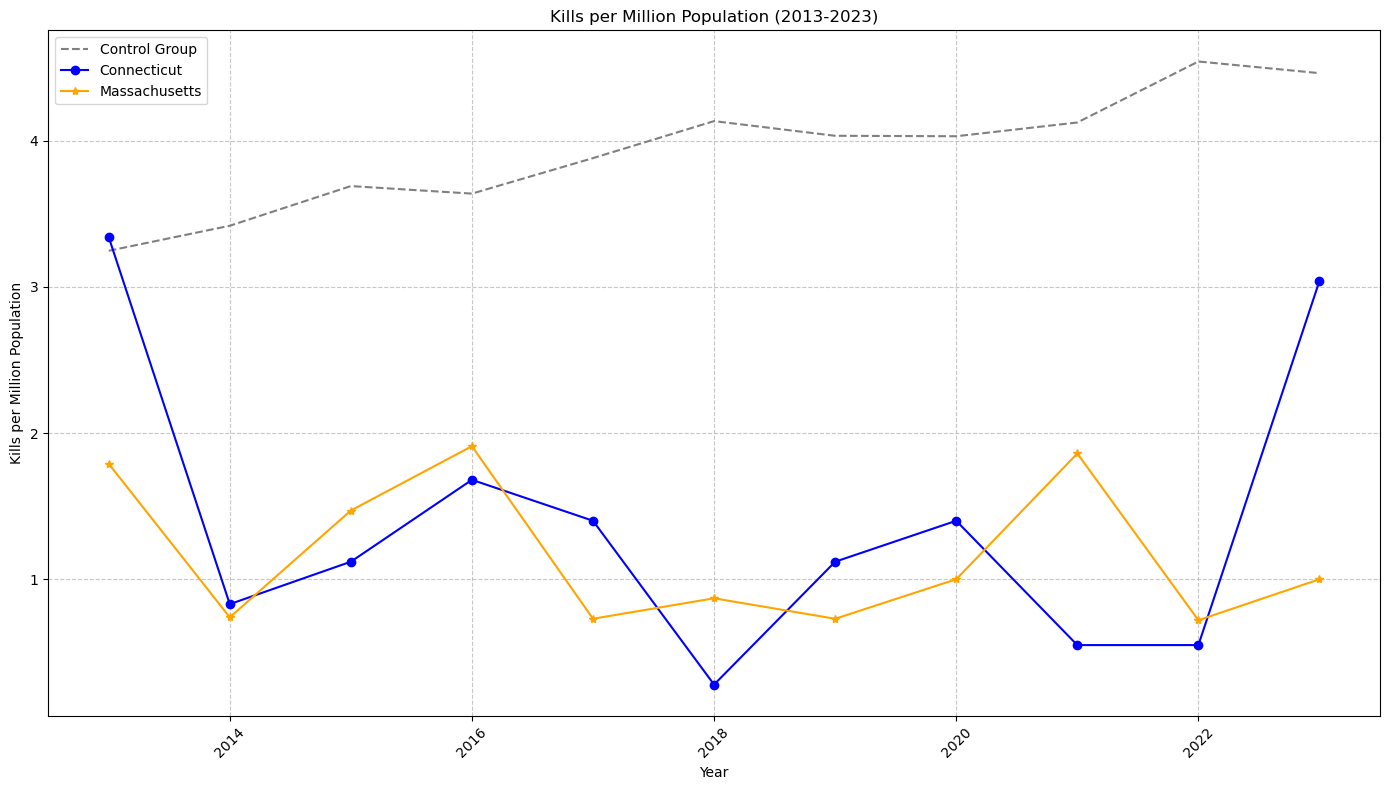


Average kills per million over the entire period:
Control Group: 3.93
Connecticut: 1.39
Massachusetts: 1.17


In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the data
df = pd.read_csv('yearly_kills_by_state_with_treatment.csv')

# Filter for years 2013-2023
df = df[(df['year'] >= 2013) & (df['year'] <= 2023)]

# Calculate control group average (states with treatment = 0)
control_group = df[df['treatment'] == 0].groupby('year')['kills_per_million'].mean().reset_index()

# Get data for each state
ct_data = df[df['state'] == 'CT']
ma_data = df[df['state'] == 'MA']

# Create the plot
plt.figure(figsize=(14, 8))

# Plot control group
plt.plot(control_group['year'], control_group['kills_per_million'], '--', label='Control Group', color='gray')

# Plot data for each state
plt.plot(ct_data['year'], ct_data['kills_per_million'], '-o', label='Connecticut', color='blue')
plt.plot(ma_data['year'], ma_data['kills_per_million'], '-*', label='Massachusetts', color='orange')

# Customize the plot
plt.xlabel('Year')
plt.ylabel('Kills per Million Population')
plt.title('Kills per Million Population (2013-2023)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save the plot
plt.savefig('kills_per_million_plot_with_additional_states.png')

# Display the plot
plt.show()

# Print average values for each group
print("\nAverage kills per million over the entire period:")
print(f"Control Group: {control_group['kills_per_million'].mean():.2f}")
print(f"Connecticut: {ct_data['kills_per_million'].mean():.2f}")
print(f"Massachusetts: {ma_data['kills_per_million'].mean():.2f}")


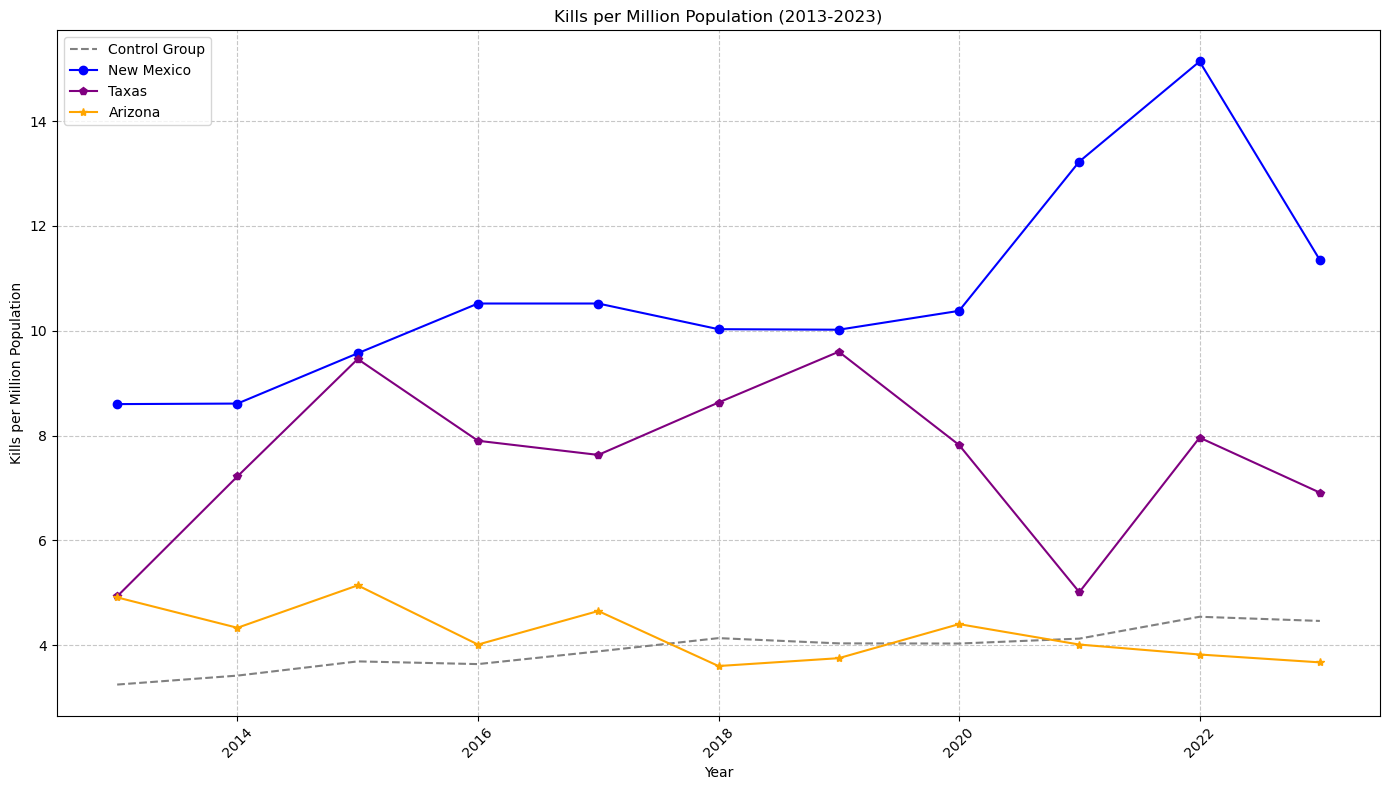


Average kills per million over the entire period:
Control Group: 3.93
Connecticut: 10.72
Rhode Island: 7.55
Massachusetts: 4.21


In [49]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the data
df = pd.read_csv('yearly_kills_by_state_with_treatment.csv')

# Filter for years 2013-2023
df = df[(df['year'] >= 2013) & (df['year'] <= 2023)]

# Calculate control group average (states with treatment = 0)
control_group = df[df['treatment'] == 0].groupby('year')['kills_per_million'].mean().reset_index()

# Get data for each state
ct_data = df[df['state'] == 'NM']
ri_data = df[df['state'] == 'OK']
ma_data = df[df['state'] == 'CA']


# Create the plot
plt.figure(figsize=(14, 8))

# Plot control group
plt.plot(control_group['year'], control_group['kills_per_million'], '--', label='Control Group', color='gray')

# Plot data for each state
plt.plot(ct_data['year'], ct_data['kills_per_million'], '-o', label='New Mexico', color='blue')
plt.plot(ri_data['year'], ri_data['kills_per_million'], '-p', label='Taxas', color='purple')
plt.plot(ma_data['year'], ma_data['kills_per_million'], '-*', label='Arizona', color='orange')


# Customize the plot
plt.xlabel('Year')
plt.ylabel('Kills per Million Population')
plt.title('Kills per Million Population (2013-2023)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save the plot
plt.savefig('kills_per_million_plot_with_additional_states.png')

# Display the plot
plt.show()

# Print average values for each group
print("\nAverage kills per million over the entire period:")
print(f"Control Group: {control_group['kills_per_million'].mean():.2f}")
print(f"Connecticut: {ct_data['kills_per_million'].mean():.2f}")
print(f"Rhode Island: {ri_data['kills_per_million'].mean():.2f}")
print(f"Massachusetts: {ma_data['kills_per_million'].mean():.2f}")


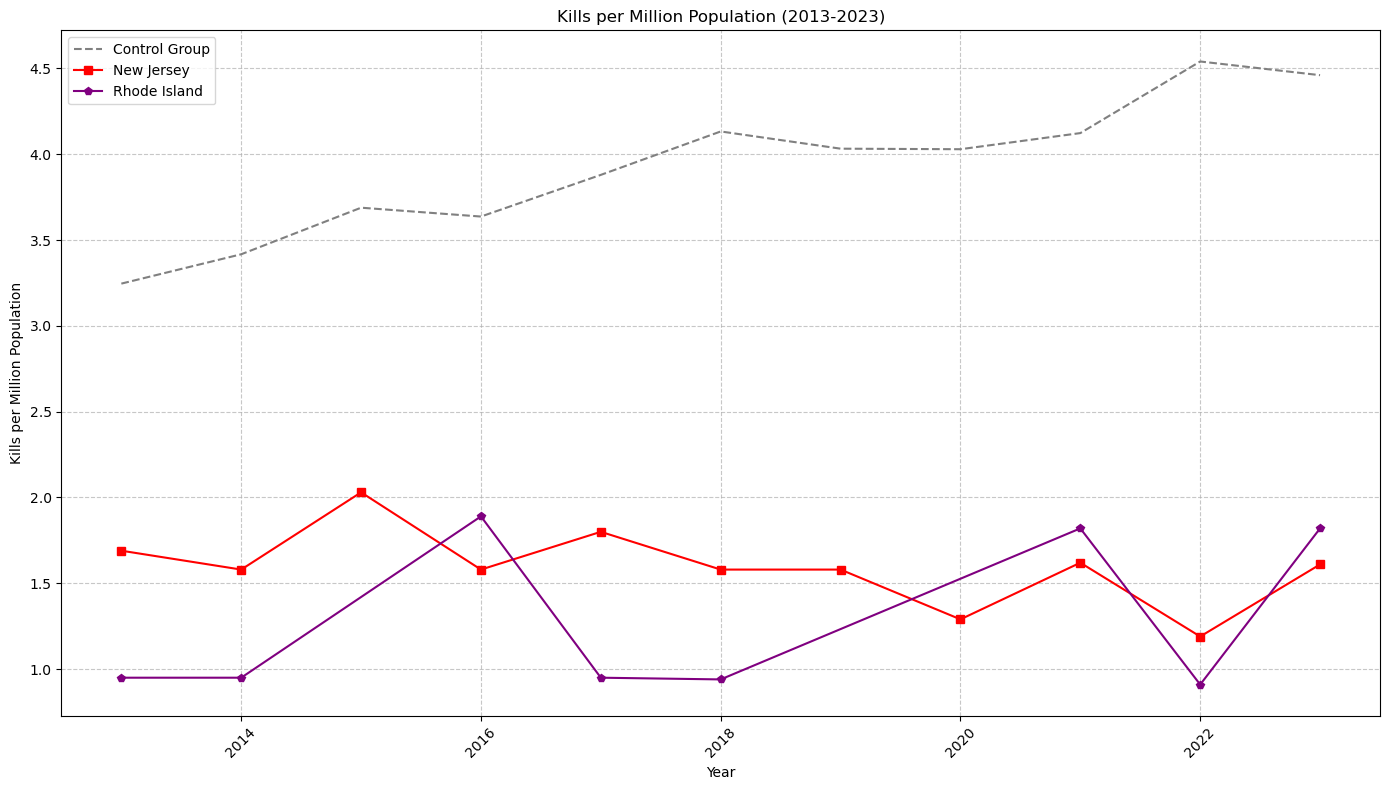


Average kills per million over the entire period:
Control Group: 3.93
New Jersey: 1.60
Rhode Island: 1.28


In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the data
df = pd.read_csv('yearly_kills_by_state_with_treatment.csv')

# Filter for years 2013-2023
df = df[(df['year'] >= 2013) & (df['year'] <= 2023)]

# Calculate control group average (states with treatment = 0)
control_group = df[df['treatment'] == 0].groupby('year')['kills_per_million'].mean().reset_index()

# Get data for each state
nj_data = df[df['state'] == 'NJ']
ri_data = df[df['state'] == 'RI']

# Create the plot
plt.figure(figsize=(14, 8))

# Plot control group
plt.plot(control_group['year'], control_group['kills_per_million'], '--', label='Control Group', color='gray')

# Plot data for each state
plt.plot(nj_data['year'], nj_data['kills_per_million'], '-s', label='New Jersey', color='red')
plt.plot(ri_data['year'], ri_data['kills_per_million'], '-p', label='Rhode Island', color='purple')

# Customize the plot
plt.xlabel('Year')
plt.ylabel('Kills per Million Population')
plt.title('Kills per Million Population (2013-2023)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save the plot
plt.savefig('kills_per_million_plot_with_additional_states.png')

# Display the plot
plt.show()

# Print average values for each group
print("\nAverage kills per million over the entire period:")
print(f"Control Group: {control_group['kills_per_million'].mean():.2f}")
print(f"New Jersey: {nj_data['kills_per_million'].mean():.2f}")
print(f"Rhode Island: {ri_data['kills_per_million'].mean():.2f}")


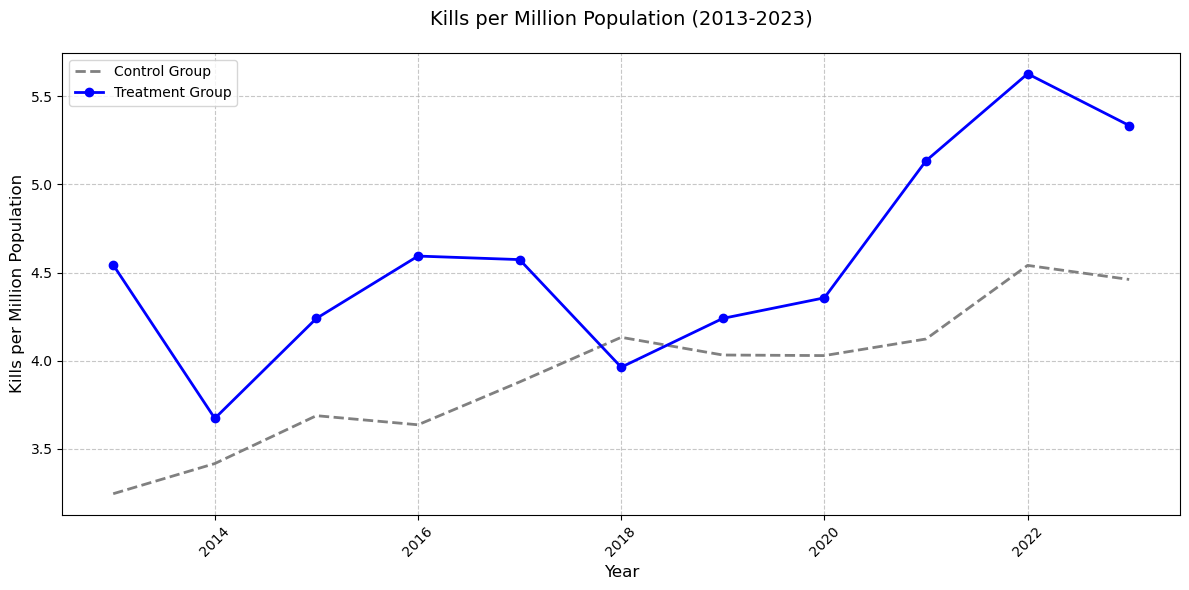


Average kills per million over the entire period:
Control Group: 3.93
Treatment Group: 4.57

Yearly values:
 year  control  treatment
 2013 3.246190   4.543333
 2014 3.417209   3.673333
 2015 3.688571   4.240000
 2016 3.636977   4.593333
 2017 3.879767   4.573333
 2018 4.132791   3.963333
 2019 4.032439   4.240000
 2020 4.029286   4.356667
 2021 4.123256   5.133333
 2022 4.540465   5.626667
 2023 4.460698   5.333333


In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the data
df = pd.read_csv('yearly_kills_by_state_with_treatment.csv')

# Filter for years 2013-2023
df = df[(df['year'] >= 2013) & (df['year'] <= 2023)]

# Calculate control group average (states with treatment = 0)
control_group = df[df['treatment'] == 0].groupby('year')['kills_per_million'].mean().reset_index()

# Calculate treatment group average (states with treatment = 1)
treatment_group = df[df['treatment'] == 1].groupby('year')['kills_per_million'].mean().reset_index()

# Create the plot
plt.figure(figsize=(12, 6))

# Plot the lines
plt.plot(control_group['year'], control_group['kills_per_million'], '--', 
         label='Control Group', color='gray', linewidth=2)
plt.plot(treatment_group['year'], treatment_group['kills_per_million'], '-o', 
         label='Treatment Group', color='blue', linewidth=2)

# Customize the plot
plt.xlabel('Year', fontsize=12)
plt.ylabel('Kills per Million Population', fontsize=12)
plt.title('Kills per Million Population (2013-2023)', fontsize=14, pad=20)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save the plot
plt.savefig('kills_per_million_plot_combined.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Print average values for each group
print("\nAverage kills per million over the entire period:")
print(f"Control Group: {control_group['kills_per_million'].mean():.2f}")
print(f"Treatment Group: {treatment_group['kills_per_million'].mean():.2f}")

# Print the yearly values for both groups
print("\nYearly values:")
yearly_comparison = pd.merge(
    control_group.rename(columns={'kills_per_million': 'control'}),
    treatment_group.rename(columns={'kills_per_million': 'treatment'}),
    on='year'
)
print(yearly_comparison.to_string(index=False))

In [52]:
dem_majority_data = {
    2013: {
        'AL': 0, 'AK': 0, 'AZ': 0, 'AR': 0, 'CA': 1, 'CO': 1, 'CT': 1, 'DE': 1, 'FL': 0,
        'GA': 0, 'HI': 1, 'ID': 0, 'IL': 1, 'IN': 0, 'IA': 0, 'KS': 0, 'KY': 0, 'LA': 0,
        'ME': 0, 'MD': 1, 'MA': 1, 'MI': 0, 'MN': 1, 'MS': 0, 'MO': 0, 'MT': 0, 'NE': 0,
        'NV': 0, 'NH': 1, 'NJ': 1, 'NM': 1, 'NY': 1, 'NC': 0, 'ND': 0, 'OH': 0, 'OK': 0,
        'OR': 1, 'PA': 0, 'RI': 1, 'SC': 0, 'SD': 0, 'TN': 0, 'TX': 0, 'UT': 0, 'VT': 1,
        'VA': 0, 'WA': 1, 'WV': 1, 'WI': 0, 'WY': 0
    },
    2014: {
        'AL': 0, 'AK': 0, 'AZ': 0, 'AR': 0, 'CA': 1, 'CO': 1, 'CT': 1, 'DE': 1, 'FL': 0,
        'GA': 0, 'HI': 1, 'ID': 0, 'IL': 1, 'IN': 0, 'IA': 0, 'KS': 0, 'KY': 0, 'LA': 0,
        'ME': 0, 'MD': 1, 'MA': 1, 'MI': 0, 'MN': 1, 'MS': 0, 'MO': 0, 'MT': 0, 'NE': 0,
        'NV': 0, 'NH': 1, 'NJ': 1, 'NM': 1, 'NY': 1, 'NC': 0, 'ND': 0, 'OH': 0, 'OK': 0,
        'OR': 1, 'PA': 0, 'RI': 1, 'SC': 0, 'SD': 0, 'TN': 0, 'TX': 0, 'UT': 0, 'VT': 1,
        'VA': 0, 'WA': 1, 'WV': 1, 'WI': 0, 'WY': 0
    },
    2015: {
        'AL': 0, 'AK': 0, 'AZ': 0, 'AR': 0, 'CA': 1, 'CO': 1, 'CT': 1, 'DE': 1, 'FL': 0,
        'GA': 0, 'HI': 1, 'ID': 0, 'IL': 1, 'IN': 0, 'IA': 0, 'KS': 0, 'KY': 0, 'LA': 0,
        'ME': 0, 'MD': 0, 'MA': 1, 'MI': 0, 'MN': 1, 'MS': 0, 'MO': 0, 'MT': 0, 'NE': 0,
        'NV': 0, 'NH': 1, 'NJ': 1, 'NM': 1, 'NY': 1, 'NC': 0, 'ND': 0, 'OH': 0, 'OK': 0,
        'OR': 1, 'PA': 0, 'RI': 1, 'SC': 0, 'SD': 0, 'TN': 0, 'TX': 0, 'UT': 0, 'VT': 1,
        'VA': 0, 'WA': 1, 'WV': 0, 'WI': 0, 'WY': 0
    },
    2016: {
        'AL': 0, 'AK': 0, 'AZ': 0, 'AR': 0, 'CA': 1, 'CO': 1, 'CT': 1, 'DE': 1, 'FL': 0,
        'GA': 0, 'HI': 1, 'ID': 0, 'IL': 1, 'IN': 0, 'IA': 0, 'KS': 0, 'KY': 0, 'LA': 0,
        'ME': 0, 'MD': 0, 'MA': 1, 'MI': 0, 'MN': 1, 'MS': 0, 'MO': 0, 'MT': 0, 'NE': 0,
        'NV': 0, 'NH': 1, 'NJ': 1, 'NM': 1, 'NY': 1, 'NC': 0, 'ND': 0, 'OH': 0, 'OK': 0,
        'OR': 1, 'PA': 0, 'RI': 1, 'SC': 0, 'SD': 0, 'TN': 0, 'TX': 0, 'UT': 0, 'VT': 1,
        'VA': 0, 'WA': 1, 'WV': 0, 'WI': 0, 'WY': 0
    },
    2017: {
        'AL': 0, 'AK': 0, 'AZ': 0, 'AR': 0, 'CA': 1, 'CO': 1, 'CT': 1, 'DE': 1, 'FL': 0,
        'GA': 0, 'HI': 1, 'ID': 0, 'IL': 1, 'IN': 0, 'IA': 0, 'KS': 0, 'KY': 0, 'LA': 0,
        'ME': 0, 'MD': 0, 'MA': 1, 'MI': 0, 'MN': 1, 'MS': 0, 'MO': 0, 'MT': 0, 'NE': 0,
        'NV': 0, 'NH': 1, 'NJ': 1, 'NM': 1, 'NY': 1, 'NC': 0, 'ND': 0, 'OH': 0, 'OK': 0,
        'OR': 1, 'PA': 0, 'RI': 1, 'SC': 0, 'SD': 0, 'TN': 0, 'TX': 0, 'UT': 0, 'VT': 1,
        'VA': 0, 'WA': 1, 'WV': 0, 'WI': 0, 'WY': 0
    },
    2018: {
        'AL': 0, 'AK': 0, 'AZ': 0, 'AR': 0, 'CA': 1, 'CO': 1, 'CT': 1, 'DE': 1, 'FL': 0,
        'GA': 0, 'HI': 1, 'ID': 0, 'IL': 1, 'IN': 0, 'IA': 0, 'KS': 0, 'KY': 0, 'LA': 0,
        'ME': 1, 'MD': 1, 'MA': 1, 'MI': 0, 'MN': 1, 'MS': 0, 'MO': 0, 'MT': 0, 'NE': 0,
        'NV': 1, 'NH': 0, 'NJ': 1, 'NM': 1, 'NY': 1, 'NC': 0, 'ND': 0, 'OH': 0, 'OK': 0,
        'OR': 1, 'PA': 0, 'RI': 1, 'SC': 0, 'SD': 0, 'TN': 0, 'TX': 0, 'UT': 0, 'VT': 1,
        'VA': 1, 'WA': 1, 'WV': 0, 'WI': 0, 'WY': 0
    },
    2019: {
        'AL': 0, 'AK': 0, 'AZ': 0, 'AR': 0, 'CA': 1, 'CO': 1, 'CT': 1, 'DE': 1, 'FL': 0,
        'GA': 0, 'HI': 1, 'ID': 0, 'IL': 1, 'IN': 0, 'IA': 0, 'KS': 0, 'KY': 0, 'LA': 0,
        'ME': 1, 'MD': 1, 'MA': 1, 'MI': 0, 'MN': 0, 'MS': 0, 'MO': 0, 'MT': 0, 'NE': 0,
        'NV': 1, 'NH': 0, 'NJ': 1, 'NM': 1, 'NY': 1, 'NC': 0, 'ND': 0, 'OH': 0, 'OK': 0,
        'OR': 1, 'PA': 0, 'RI': 1, 'SC': 0, 'SD': 0, 'TN': 0, 'TX': 0, 'UT': 0, 'VT': 1,
        'VA': 0, 'WA': 1, 'WV': 0, 'WI': 0, 'WY': 0
    },
    2020: {
        'AL': 0, 'AK': 0, 'AZ': 0, 'AR': 0, 'CA': 1, 'CO': 1, 'CT': 1, 'DE': 1, 'FL': 0,
        'GA': 0, 'HI': 1, 'ID': 0, 'IL': 1, 'IN': 0, 'IA': 0, 'KS': 0, 'KY': 0, 'LA': 0,
        'ME': 1, 'MD': 1, 'MA': 1, 'MI': 0, 'MN': 0, 'MS': 0, 'MO': 0, 'MT': 0, 'NE': 0,
        'NV': 1, 'NH': 0, 'NJ': 1, 'NM': 1, 'NY': 1, 'NC': 0, 'ND': 0, 'OH': 0, 'OK': 0,
        'OR': 1, 'PA': 0, 'RI': 1, 'SC': 0, 'SD': 0, 'TN': 0, 'TX': 0, 'UT': 0, 'VT': 1,
        'VA': 0, 'WA': 1, 'WV': 0, 'WI': 0, 'WY': 0
    },
    2021: {
        'AL': 0, 'AK': 0, 'AZ': 0, 'AR': 0, 'CA': 1, 'CO': 1, 'CT': 1, 'DE': 1, 'FL': 0,
        'GA': 0, 'HI': 1, 'ID': 0, 'IL': 1, 'IN': 0, 'IA': 0, 'KS': 0, 'KY': 0, 'LA': 0,
        'ME': 1, 'MD': 1, 'MA': 1, 'MI': 0, 'MN': 0, 'MS': 0, 'MO': 0, 'MT': 0, 'NE': 0,
        'NV': 1, 'NH': 0, 'NJ': 1, 'NM': 1, 'NY': 1, 'NC': 0, 'ND': 0, 'OH': 0, 'OK': 0,
        'OR': 1, 'PA': 0, 'RI': 1, 'SC': 0, 'SD': 0, 'TN': 0, 'TX': 0, 'UT': 0, 'VT': 1,
        'VA': 0, 'WA': 1, 'WV': 0, 'WI': 0, 'WY': 0
    },
    2022: {
        'AL': 0, 'AK': 0, 'AZ': 0, 'AR': 0, 'CA': 1, 'CO': 1, 'CT': 1, 'DE': 1, 'FL': 0,
        'GA': 0, 'HI': 1, 'ID': 0, 'IL': 1, 'IN': 0, 'IA': 0, 'KS': 0, 'KY': 0, 'LA': 0,
        'ME': 1, 'MD': 1, 'MA': 1, 'MI': 1, 'MN': 1, 'MS': 0, 'MO': 0, 'MT': 0, 'NE': 0,
        'NV': 1, 'NH': 0, 'NJ': 1, 'NM': 1, 'NY': 1, 'NC': 0, 'ND': 0, 'OH': 0, 'OK': 0,
        'OR': 1, 'PA': 1, 'RI': 1, 'SC': 0, 'SD': 0, 'TN': 0, 'TX': 0, 'UT': 0, 'VT': 1,
        'VA': 0, 'WA': 1, 'WV': 0, 'WI': 0, 'WY': 0
    },
    2023: {
        'AL': 0, 'AK': 0, 'AZ': 0, 'AR': 0, 'CA': 1, 'CO': 1, 'CT': 1, 'DE': 1, 'FL': 0,
        'GA': 0, 'HI': 1, 'ID': 0, 'IL': 1, 'IN': 0, 'IA': 0, 'KS': 0, 'KY': 0, 'LA': 0,
        'ME': 1, 'MD': 1, 'MA': 1, 'MI': 1, 'MN': 1, 'MS': 0, 'MO': 0, 'MT': 0, 'NE': 0,
        'NV': 1, 'NH': 0, 'NJ': 1, 'NM': 1, 'NY': 1, 'NC': 0, 'ND': 0, 'OH': 0, 'OK': 0,
        'OR': 1, 'PA': 1, 'RI': 1, 'SC': 0, 'SD': 0, 'TN': 0, 'TX': 0, 'UT': 0, 'VT': 1,
        'VA': 0, 'WA': 1, 'WV': 0, 'WI': 1, 'WY': 0
    }
}


# dem_gov: 1 if the governor is a Democrat, 0 otherwise
dem_gov_data = {
    2013: {
        'AL': 0, 'AK': 0, 'AZ': 0, 'AR': 0, 'CA': 1, 'CO': 1, 'CT': 1, 'DE': 1, 'FL': 0,
        'GA': 0, 'HI': 1, 'ID': 0, 'IL': 1, 'IN': 0, 'IA': 0, 'KS': 0, 'KY': 0, 'LA': 0,
        'ME': 0, 'MD': 1, 'MA': 1, 'MI': 0, 'MN': 1, 'MS': 0, 'MO': 0, 'MT': 1, 'NE': 0,
        'NV': 0, 'NH': 1, 'NJ': 0, 'NM': 1, 'NY': 1, 'NC': 0, 'ND': 0, 'OH': 0, 'OK': 0,
        'OR': 1, 'PA': 0, 'RI': 1, 'SC': 0, 'SD': 0, 'TN': 0, 'TX': 0, 'UT': 0, 'VT': 1,
        'VA': 0, 'WA': 1, 'WV': 1, 'WI': 0, 'WY': 0
    },
    2014: {
        'AL': 0, 'AK': 0, 'AZ': 0, 'AR': 0, 'CA': 1, 'CO': 1, 'CT': 1, 'DE': 1, 'FL': 0,
        'GA': 0, 'HI': 1, 'ID': 0, 'IL': 1, 'IN': 0, 'IA': 0, 'KS': 0, 'KY': 0, 'LA': 0,
        'ME': 0, 'MD': 1, 'MA': 1, 'MI': 0, 'MN': 1, 'MS': 0, 'MO': 0, 'MT': 1, 'NE': 0,
        'NV': 0, 'NH': 1, 'NJ': 0, 'NM': 1, 'NY': 1, 'NC': 0, 'ND': 0, 'OH': 0, 'OK': 0,
        'OR': 1, 'PA': 0, 'RI': 1, 'SC': 0, 'SD': 0, 'TN': 0, 'TX': 0, 'UT': 0, 'VT': 1,
        'VA': 0, 'WA': 1, 'WV': 1, 'WI': 0, 'WY': 0
    },
    2015: {
        'AL': 0, 'AK': 0, 'AZ': 0, 'AR': 0, 'CA': 1, 'CO': 1, 'CT': 1, 'DE': 1, 'FL': 0,
        'GA': 0, 'HI': 1, 'ID': 0, 'IL': 1, 'IN': 0, 'IA': 0, 'KS': 0, 'KY': 0, 'LA': 0,
        'ME': 0, 'MD': 0, 'MA': 0, 'MI': 0, 'MN': 1, 'MS': 0, 'MO': 0, 'MT': 1, 'NE': 0,
        'NV': 0, 'NH': 1, 'NJ': 0, 'NM': 1, 'NY': 1, 'NC': 0, 'ND': 0, 'OH': 0, 'OK': 0,
        'OR': 1, 'PA': 0, 'RI': 1, 'SC': 0, 'SD': 0, 'TN': 0, 'TX': 0, 'UT': 0, 'VT': 1,
        'VA': 0, 'WA': 1, 'WV': 1, 'WI': 0, 'WY': 0
    },
    2016: {
        'AL': 0, 'AK': 0, 'AZ': 0, 'AR': 0, 'CA': 1, 'CO': 1, 'CT': 1, 'DE': 1, 'FL': 0,
        'GA': 0, 'HI': 1, 'ID': 0, 'IL': 1, 'IN': 0, 'IA': 0, 'KS': 0, 'KY': 0, 'LA': 1,
        'ME': 0, 'MD': 0, 'MA': 0, 'MI': 0, 'MN': 1, 'MS': 0, 'MO': 0, 'MT': 1, 'NE': 0,
        'NV': 0, 'NH': 1, 'NJ': 0, 'NM': 1, 'NY': 1, 'NC': 0, 'ND': 0, 'OH': 0, 'OK': 0,
        'OR': 1, 'PA': 0, 'RI': 1, 'SC': 0, 'SD': 0, 'TN': 0, 'TX': 0, 'UT': 0, 'VT': 1,
        'VA': 0, 'WA': 1, 'WV': 1, 'WI': 0, 'WY': 0
    },
    2017: {
        'AL': 0, 'AK': 0, 'AZ': 0, 'AR': 0, 'CA': 1, 'CO': 1, 'CT': 1, 'DE': 1, 'FL': 0,
        'GA': 0, 'HI': 1, 'ID': 0, 'IL': 1, 'IN': 0, 'IA': 0, 'KS': 0, 'KY': 0, 'LA': 1,
        'ME': 0, 'MD': 0, 'MA': 0, 'MI': 0, 'MN': 1, 'MS': 0, 'MO': 0, 'MT': 1, 'NE': 0,
        'NV': 0, 'NH': 0, 'NJ': 0, 'NM': 1, 'NY': 1, 'NC': 0, 'ND': 0, 'OH': 0, 'OK': 0,
        'OR': 1, 'PA': 0, 'RI': 1, 'SC': 0, 'SD': 0, 'TN': 0, 'TX': 0, 'UT': 0, 'VT': 1,
        'VA': 0, 'WA': 1, 'WV': 1, 'WI': 0, 'WY': 0
    },
    2018: {
        'AL': 0, 'AK': 0, 'AZ': 0, 'AR': 0, 'CA': 1, 'CO': 1, 'CT': 1, 'DE': 1, 'FL': 0,
        'GA': 0, 'HI': 1, 'ID': 0, 'IL': 1, 'IN': 0, 'IA': 0, 'KS': 0, 'KY': 0, 'LA': 0,
        'ME': 0, 'MD': 0, 'MA': 0, 'MI': 0, 'MN': 1, 'MS': 0, 'MO': 0, 'MT': 1, 'NE': 0,
        'NV': 1, 'NH': 0, 'NJ': 1, 'NM': 1, 'NY': 1, 'NC': 0, 'ND': 0, 'OH': 0, 'OK': 0,
        'OR': 1, 'PA': 0, 'RI': 1, 'SC': 0, 'SD': 0, 'TN': 0, 'TX': 0, 'UT': 0, 'VT': 1,
        'VA': 1, 'WA': 1, 'WV': 0, 'WI': 0, 'WY': 0
    },
    2019: {
        'AL': 0, 'AK': 0, 'AZ': 0, 'AR': 0, 'CA': 1, 'CO': 1, 'CT': 1, 'DE': 1, 'FL': 0,
        'GA': 0, 'HI': 1, 'ID': 0, 'IL': 1, 'IN': 0, 'IA': 0, 'KS': 1, 'KY': 0, 'LA': 1,
        'ME': 1, 'MD': 0, 'MA': 1, 'MI': 1, 'MN': 1, 'MS': 0, 'MO': 0, 'MT': 0, 'NE': 0,
        'NV': 1, 'NH': 0, 'NJ': 1, 'NM': 1, 'NY': 1, 'NC': 0, 'ND': 0, 'OH': 0, 'OK': 0,
        'OR': 1, 'PA': 1, 'RI': 1, 'SC': 0, 'SD': 0, 'TN': 0, 'TX': 0, 'UT': 0, 'VT': 1,
        'VA': 1, 'WA': 1, 'WV': 0, 'WI': 1, 'WY': 0
    },
    2020: {
        'AL': 0, 'AK': 0, 'AZ': 0, 'AR': 0, 'CA': 1, 'CO': 1, 'CT': 1, 'DE': 1, 'FL': 0,
        'GA': 0, 'HI': 1, 'ID': 0, 'IL': 1, 'IN': 0, 'IA': 0, 'KS': 1, 'KY': 0, 'LA': 1,
        'ME': 1, 'MD': 0, 'MA': 1, 'MI': 1, 'MN': 1, 'MS': 0, 'MO': 0, 'MT': 0, 'NE': 0,
        'NV': 1, 'NH': 0, 'NJ': 1, 'NM': 1, 'NY': 1, 'NC': 0, 'ND': 0, 'OH': 0, 'OK': 0,
        'OR': 1, 'PA': 1, 'RI': 1, 'SC': 0, 'SD': 0, 'TN': 0, 'TX': 0, 'UT': 0, 'VT': 1,
        'VA': 1, 'WA': 1, 'WV': 0, 'WI': 1, 'WY': 0
    },
    2021: {
        'AL': 0, 'AK': 0, 'AZ': 0, 'AR': 0, 'CA': 1, 'CO': 1, 'CT': 1, 'DE': 1, 'FL': 0,
        'GA': 0, 'HI': 1, 'ID': 0, 'IL': 1, 'IN': 0, 'IA': 0, 'KS': 1, 'KY': 0, 'LA': 1,
        'ME': 1, 'MD': 0, 'MA': 1, 'MI': 1, 'MN': 1, 'MS': 0, 'MO': 0, 'MT': 0, 'NE': 0,
        'NV': 1, 'NH': 0, 'NJ': 1, 'NM': 1, 'NY': 1, 'NC': 0, 'ND': 0, 'OH': 0, 'OK': 0,
        'OR': 1, 'PA': 1, 'RI': 1, 'SC': 0, 'SD': 0, 'TN': 0, 'TX': 0, 'UT': 0, 'VT': 1,
        'VA': 1, 'WA': 1, 'WV': 0, 'WI': 1, 'WY': 0
    },
    2022: {
        'AL': 0, 'AK': 0, 'AZ': 0, 'AR': 0, 'CA': 1, 'CO': 1, 'CT': 1, 'DE': 1, 'FL': 0,
        'GA': 0, 'HI': 1, 'ID': 0, 'IL': 1, 'IN': 0, 'IA': 0, 'KS': 1, 'KY': 0, 'LA': 1,
        'ME': 1, 'MD': 0, 'MA': 1, 'MI': 1, 'MN': 1, 'MS': 0, 'MO': 0, 'MT': 0, 'NE': 0,
        'NV': 1, 'NH': 0, 'NJ': 1, 'NM': 1, 'NY': 1, 'NC': 0, 'ND': 0, 'OH': 0, 'OK': 0,
        'OR': 1, 'PA': 1, 'RI': 1, 'SC': 0, 'SD': 0, 'TN': 0, 'TX': 0, 'UT': 0, 'VT': 1,
        'VA': 1, 'WA': 1, 'WV': 0, 'WI': 1, 'WY': 0
    },
    2023: {
        'AL': 0, 'AK': 0, 'AZ': 1, 'AR': 0, 'CA': 1, 'CO': 1, 'CT': 1, 'DE': 1, 'FL': 0,
        'GA': 0, 'HI': 1, 'ID': 0, 'IL': 1, 'IN': 0, 'IA': 0, 'KS': 1, 'KY': 0, 'LA': 0,
        'ME': 1, 'MD': 1, 'MA': 1, 'MI': 1, 'MN': 1, 'MS': 0, 'MO': 0, 'MT': 0, 'NE': 0,
        'NV': 1, 'NH': 0, 'NJ': 1, 'NM': 1, 'NY': 1, 'NC': 0, 'ND': 0, 'OH': 0, 'OK': 0,
        'OR': 1, 'PA': 1, 'RI': 1, 'SC': 0, 'SD': 0, 'TN': 0, 'TX': 0, 'UT': 0, 'VT': 1,
        'VA': 0, 'WA': 1, 'WV': 0, 'WI': 1, 'WY': 0
    }
}

In [53]:
import pandas as pd

# First, let's convert the dictionary data to dataframes
dem_majority_rows = []
dem_gov_rows = []

for year in dem_majority_data:
    for state, value in dem_majority_data[year].items():
        dem_majority_rows.append({'year': year, 'state': state, 'dem_majority': value})
        
for year in dem_gov_data:
    for state, value in dem_gov_data[year].items():
        dem_gov_rows.append({'year': year, 'state': state, 'dem_governor': value})

# Create dataframes from the rows
dem_majority_df = pd.DataFrame(dem_majority_rows)
dem_gov_df = pd.DataFrame(dem_gov_rows)

# Read the existing CSV file
df = pd.read_csv('yearly_kills_by_state_with_treatment.csv')

# Merge with dem_majority data
df = pd.merge(df, dem_majority_df, on=['state', 'year'], how='left')

# Merge with dem_governor data
df = pd.merge(df, dem_gov_df, on=['state', 'year'], how='left')

# Save the updated dataframe
df.to_csv('yearly_kills_by_state_with_political.csv', index=False)

print("First few rows of the updated dataset:")
print(df.head())

print("\nColumns in the updated dataset:")
print(df.columns.tolist())

First few rows of the updated dataset:
  state  year  Bodycam_Policy  kills_per_million  treatment  dem_majority  \
0    AK  2013             0.0               5.43          0             0   
1    AK  2014             0.0               2.72          0             0   
2    AK  2015             0.0               5.42          0             0   
3    AK  2016             0.0               9.44          0             0   
4    AK  2017             0.0              10.82          0             0   

   dem_governor  
0             0  
1             0  
2             0  
3             0  
4             0  

Columns in the updated dataset:
['state', 'year', 'Bodycam_Policy', 'kills_per_million', 'treatment', 'dem_majority', 'dem_governor']


In [54]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

# Read the data
df = pd.read_csv('yearly_kills_by_state_with_political.csv')

# Filter for just 2019 and 2023
df = df[df['year'].isin([2019, 2023])]

# Create post indicator (1 for 2023, 0 for 2019)
df['post'] = (df['year'] == 2023).astype(int)

# Create treatment group indicator (1 for states with treatment=1, 0 otherwise)
df['treated'] = (df['treatment'] == 1).astype(int)

# Create interaction term
df['did'] = df['treated'] * df['post']

# Add political controls
df['dem_majority'] = df['dem_majority'].astype(int)
df['dem_governor'] = df['dem_governor'].astype(int)

# Prepare the regression variables
y = df['kills_per_million']
X = pd.DataFrame({
    'Intercept': 1,
    'Post': df['post'],
    'Treated': df['treated'],
    'DiD': df['did'],
    'Dem_Majority': df['dem_majority'],
    'Dem_Governor': df['dem_governor']
})

# Run the regression
model = sm.OLS(y, X)
results = model.fit(cov_type='HC1')  # Using robust standard errors

# Print detailed results
print("Difference-in-Differences Regression Results")
print("===========================================")
print(results.summary())

# Calculate and print means for easier interpretation
print("\nMean Kills per Million by Group and Period:")
print("===========================================")
means = df.groupby(['treated', 'post'])['kills_per_million'].mean().unstack()
print("\nTreatment Group:")
print(means.loc[1])
print("\nControl Group:")
print(means.loc[0])

# Calculate the raw difference-in-differences
print("\nRaw Difference-in-Differences Calculation:")
print("========================================")
treat_diff = means.loc[1, 1] - means.loc[1, 0]
control_diff = means.loc[0, 1] - means.loc[0, 0]
raw_did = treat_diff - control_diff
print(f"Treatment Group Change: {treat_diff:.3f}")
print(f"Control Group Change: {control_diff:.3f}")
print(f"Raw DiD Estimate: {raw_did:.3f}")

# Print the number of observations in each group
print("\nNumber of Observations:")
print("=====================")
print(df.groupby(['treated', 'post']).size().unstack())

Difference-in-Differences Regression Results
                            OLS Regression Results                            
Dep. Variable:      kills_per_million   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     2.279
Date:                Mon, 16 Dec 2024   Prob (F-statistic):             0.0531
Time:                        10:59:36   Log-Likelihood:                -218.26
No. Observations:                  98   AIC:                             448.5
Df Residuals:                      92   BIC:                             464.0
Df Model:                           5                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Int

In [55]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

# Read the data
df = pd.read_csv('yearly_kills_by_state_with_political.csv')

# Filter for just 2019 and 2023
df = df[df['year'].isin([2019, 2023])]

# Create post indicator (1 for 2023, 0 for 2019)
df['post'] = (df['year'] == 2023).astype(int)

# Function to run DiD regression for a specific treatment state
def run_did_regression(data, treatment_state):
    # Create dataset with only control states and the specific treatment state
    state_data = data[(data['state'] == treatment_state) | (data['treatment'] == 0)].copy()
    
    # Create treatment indicator for specific state
    state_data['treated'] = (state_data['state'] == treatment_state).astype(int)
    
    # Create interaction term
    state_data['did'] = state_data['treated'] * state_data['post']
    
    # Prepare regression variables
    y = state_data['kills_per_million']
    X = pd.DataFrame({
        'Intercept': 1,
        'Post': state_data['post'],
        'Treated': state_data['treated'],
        'DiD': state_data['did'],
        'Dem_Majority': state_data['dem_majority'],
        'Dem_Governor': state_data['dem_governor']
    })
    
    # Run regression
    model = sm.OLS(y, X)
    results = model.fit(cov_type='HC1')
    
    # Calculate means
    means = state_data.groupby(['treated', 'post'])['kills_per_million'].mean().unstack()
    
    # Calculate raw DiD
    treat_diff = means.loc[1, 1] - means.loc[1, 0]
    control_diff = means.loc[0, 1] - means.loc[0, 0]
    raw_did = treat_diff - control_diff
    
    return results, means, treat_diff, control_diff, raw_did

# Run analysis for each treatment state
treatment_states = ['CT', 'NJ', 'NM']

for state in treatment_states:
    print(f"\n{'='*50}")
    print(f"DiD Analysis for {state}")
    print(f"{'='*50}")
    
    results, means, treat_diff, control_diff, raw_did = run_did_regression(df, state)
    
    print("\nRegression Results:")
    print(results.summary().tables[1])  # Print only coefficient table for brevity
    
    print("\nMean Kills per Million:")
    print(f"\n{state}:")
    print(means.loc[1])
    print("\nControl Group:")
    print(means.loc[0])
    
    print("\nRaw Differences:")
    print(f"{state} Change: {treat_diff:.3f}")
    print(f"Control Group Change: {control_diff:.3f}")
    print(f"Raw DiD Estimate: {raw_did:.3f}")
    
    # Print sample sizes
    sample_sizes = df[(df['state'] == state) | (df['treatment'] == 0)].groupby(['state']).size()
    print("\nNumber of Observations:")
    print(f"{state}: {sample_sizes[state]}")
    print(f"Control Group: {sample_sizes.sum() - sample_sizes[state]}")


DiD Analysis for CT

Regression Results:
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        4.6777      0.424     11.035      0.000       3.847       5.508
Post             0.3930      0.489      0.804      0.422      -0.565       1.351
Treated         -2.0202      0.465     -4.345      0.000      -2.932      -1.109
DiD              1.5270      0.489      3.123      0.002       0.569       2.485
Dem_Majority     0.0453      0.772      0.059      0.953      -1.468       1.559
Dem_Governor    -1.5828      0.747     -2.120      0.034      -3.046      -0.120

Mean Kills per Million:

CT:
post
0    1.12
1    3.04
Name: 1, dtype: float64

Control Group:
post
0    4.032439
1    4.460698
Name: 0, dtype: float64

Raw Differences:
CT Change: 1.920
Control Group Change: 0.428
Raw DiD Estimate: 1.492

Number of Observations:
CT: 2
Control Group: 84

DiD Analysis for NJ



/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4
  warnings.warn('covariance of constraints does not have full '
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4
  warnings.warn('covariance of constraints does not have full '
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4
  warnings.warn('covariance of constraints does not have full '


In [ ]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

# Read the data
df = pd.read_csv('yearly_kills_by_state_with_political.csv')

# Filter for just 2019 and 2023
df = df[df['year'].isin([2019, 2023])]

# Create post indicator (1 for 2023, 0 for 2019)
df['post'] = (df['year'] == 2023).astype(int)

# Function to run DiD regression for a specific treatment state
def run_did_regression(data, treatment_state):
    # Create dataset with only control states and the specific treatment state
    state_data = data[(data['state'] == treatment_state) | (data['treatment'] == 0)].copy()
    
    # Create treatment indicator for specific state
    state_data['treated'] = (state_data['state'] == treatment_state).astype(int)
    
    # Create interaction term
    state_data['did'] = state_data['treated'] * state_data['post']
    
    # Prepare regression variables
    y = state_data['kills_per_million']
    X = pd.DataFrame({
        'Intercept': 1,
        'Post': state_data['post'],
        'Treated': state_data['treated'],
        'DiD': state_data['did'],
        'Dem_Majority': state_data['dem_majority'],
        'Dem_Governor': state_data['dem_governor']
    })
    
    # Run regression
    model = sm.OLS(y, X)
    results = model.fit(cov_type='HC1')
    
    # Calculate means
    means = state_data.groupby(['treated', 'post'])['kills_per_million'].mean().unstack()
    
    # Calculate raw DiD
    treat_diff = means.loc[1, 1] - means.loc[1, 0]
    control_diff = means.loc[0, 1] - means.loc[0, 0]
    raw_did = treat_diff - control_diff
    
    return results, means, treat_diff, control_diff, raw_did

# Run analysis for each treatment state
treatment_states = ['CT', 'NJ', 'NM']

for state in treatment_states:
    print(f"\n{'='*50}")
    print(f"DiD Analysis for {state}")
    print(f"{'='*50}")
    
    results, means, treat_diff, control_diff, raw_did = run_did_regression(df, state)
    
    print("\nRegression Results:")
    print(results.summary().tables[1])  # Print only coefficient table for brevity
    
    print("\nMean Kills per Million:")
    print(f"\n{state}:")
    print(means.loc[1])
    print("\nControl Group:")
    print(means.loc[0])
    
    print("\nRaw Differences:")
    print(f"{state} Change: {treat_diff:.3f}")
    print(f"Control Group Change: {control_diff:.3f}")
    print(f"Raw DiD Estimate: {raw_did:.3f}")
    
    # Print sample sizes
    sample_sizes = df[(df['state'] == state) | (df['treatment'] == 0)].groupby(['state']).size()
    print("\nNumber of Observations:")
    print(f"{state}: {sample_sizes[state]}")
    print(f"Control Group: {sample_sizes.sum() - sample_sizes[state]}")

In [56]:
import pandas as pd
import numpy as np

def clean_and_merge_data():
    # Create DataFrames for both files
    kills_df = pd.read_csv('yearly_kills_by_state_with_political.csv')
    crime_df = pd.read_csv('SS154 assignments - crime rate - SS154 assignments - crime rate.csv')
    
    # Clean up the crime rate data
    # Remove the URL column if it exists
    if 'https://cde.ucr.cjis.gov/LATEST/webapp/#' in crime_df.columns:
        crime_df = crime_df.drop('https://cde.ucr.cjis.gov/LATEST/webapp/#', axis=1)
    
    # Clean column names
    crime_df.columns = crime_df.columns.str.strip()
    crime_df.columns = crime_df.columns.str.replace('_per_pipulation', '_per_population')
    crime_df.columns = crime_df.columns.str.replace('homicity_per_populaiton', 'homicide_per_population')
    
    # Convert numeric columns with commas to float
    numeric_columns = crime_df.select_dtypes(include=['object']).columns
    for col in numeric_columns:
        try:
            crime_df[col] = crime_df[col].str.replace(',', '').astype(float)
        except:
            continue
    
    # Merge the datasets
    merged_df = pd.merge(
        kills_df,
        crime_df,
        how='left',
        left_on=['state', 'year'],
        right_on=['state_abbr', 'year']
    )
    
    # Clean up merged dataset
    # Remove duplicate columns
    if 'state_abbr' in merged_df.columns:
        merged_df = merged_df.drop('state_abbr', axis=1)
    if 'state_name' in merged_df.columns:
        merged_df = merged_df.drop('state_name', axis=1)
    
    # Sort the data
    merged_df = merged_df.sort_values(['state', 'year'])
    
    # Reset index
    merged_df = merged_df.reset_index(drop=True)
    
    return merged_df

# Create the merged dataset
merged_data = clean_and_merge_data()

# Display some basic information about the merged dataset
print(f"Shape of merged dataset: {merged_data.shape}")
print("\nColumns in merged dataset:")
for col in merged_data.columns:
    print(col)

# Calculate correlations between key columns
key_columns = ['kills_per_million', 'violent_crime_per_population', 
               'homicide_per_population', 'Bodycam_Policy', 'dem_majority']
correlation_matrix = merged_data[key_columns].corr()
print("\nCorrelation matrix between key variables:")
print(correlation_matrix)

Shape of merged dataset: (546, 28)

Columns in merged dataset:
state
year
Bodycam_Policy
kills_per_million
treatment
dem_majority
dem_governor
total crimes
total crimes_per_population
population
violent_crime
violent_crime_per_population
homicide
homicide_per_population
rape_revised
rape_revised_per_population
robbery
robbery_per_population
aggravated_assault
Unnamed: 15
property_crime
property_crime_per_population
burglary
burglary_per_population
larceny
larceny_per_population
motor_vehicle_theft
motor_vehicle_theft_per_population

Correlation matrix between key variables:
                              kills_per_million  violent_crime_per_population  \
kills_per_million                      1.000000                      0.491721   
violent_crime_per_population           0.491721                      1.000000   
homicide_per_population                0.322644                      0.666441   
Bodycam_Policy                         0.101172                      0.138398   
dem_majority  

In [59]:
# Remove specified columns and clean the dataset
def clean_merged_data(df):
    columns_to_remove = [
        'population', 
        'total crimes', 
        'aggregated_assault',
        'property_crime',
        'burglary',
        'larceny',
        'motor_vehicle_theft',
        'violent_crime',
        'homicide',
        'rape_revised',
        'robbery',
        'aggravated_assault'



    ]
    
    # Remove columns if they exist
    existing_columns = [col for col in columns_to_remove if col in df.columns]
    cleaned_df = df.drop(columns=existing_columns)
    
    # Remove any unnamed columns
    unnamed_cols = [col for col in cleaned_df.columns if 'Unnamed' in str(col)]
    cleaned_df = cleaned_df.drop(columns=unnamed_cols)
    
    return cleaned_df

# Clean the merged dataset
cleaned_data = clean_merged_data(merged_data)

# Display information about the cleaned dataset
print("Shape of cleaned dataset:", cleaned_data.shape)
print("\nRemaining columns:")
for col in cleaned_data.columns:
    print(col)

# Display first few rows of cleaned dataset
print("\nFirst few rows of cleaned dataset:")
print(cleaned_data.head())

# Calculate summary statistics for numeric columns
print("\nSummary statistics for numeric columns:")
print(cleaned_data.describe())

Shape of cleaned dataset: (546, 16)

Remaining columns:
state
year
Bodycam_Policy
kills_per_million
treatment
dem_majority
dem_governor
total crimes_per_population
violent_crime_per_population
homicide_per_population
rape_revised_per_population
robbery_per_population
property_crime_per_population
burglary_per_population
larceny_per_population
motor_vehicle_theft_per_population

First few rows of cleaned dataset:
  state  year  Bodycam_Policy  kills_per_million  treatment  dem_majority  \
0    AK  2013             0.0               5.43          0             0   
1    AK  2014             0.0               2.72          0             0   
2    AK  2015             0.0               5.42          0             0   
3    AK  2016             0.0               9.44          0             0   
4    AK  2017             0.0              10.82          0             0   

   dem_governor  total crimes_per_population  violent_crime_per_population  \
0             0                     0.07120

In [60]:
output_filename = 'cleaned_state_crime_data.csv'
cleaned_data.to_csv(output_filename, index=False)